## SARIMA model

In [2]:
import pandas as pd

passengers_df = pd.read_csv("data/air-passengers.csv")

passengers_df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


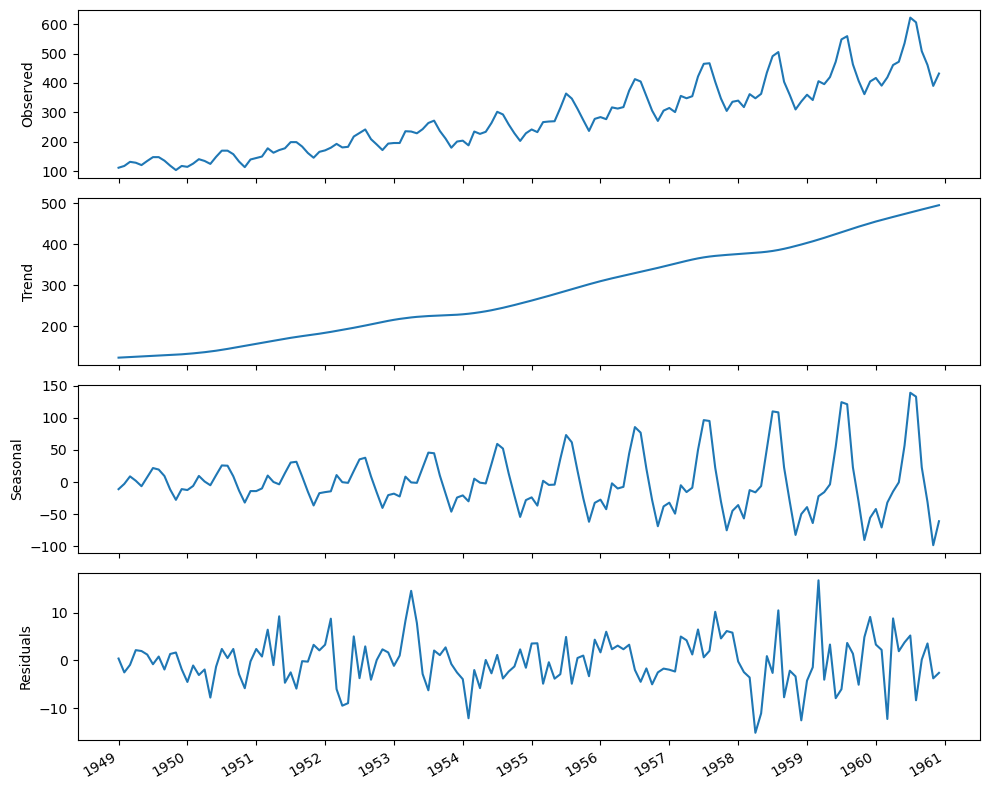

In [3]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import numpy as np

decomposition = STL(passengers_df["Passengers"], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(decomposition.observed)
ax1.set_ylabel("Observed")

ax2.plot(decomposition.trend)
ax2.set_ylabel("Trend")

ax3.plot(decomposition.seasonal)
ax3.set_ylabel("Seasonal")

ax4.plot(decomposition.resid)
ax4.set_ylabel("Residuals")

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

In [4]:
# Forecasting ARIMA
from statsmodels.tsa.stattools import adfuller

ad_fuller_test = adfuller(passengers_df["Passengers"])

print(f"ADF stats: {ad_fuller_test[0]}")
print(f"p-value: {ad_fuller_test[1]}")

ADF stats: 0.8153688792060498
p-value: 0.991880243437641


In [5]:
diff_df = np.diff(passengers_df["Passengers"], n=1)

ad_fuller_test = adfuller(diff_df)
print(f"ADF stats: {ad_fuller_test[0]}")
print(f"p-value: {ad_fuller_test[1]}")

ADF stats: -2.8292668241700047
p-value: 0.05421329028382478


In [6]:
diff_df2 = np.diff(diff_df, n=1)

ad_fuller_test = adfuller(diff_df2)
print(f"ADF stats: {ad_fuller_test[0]}")
print(f"p-value: {ad_fuller_test[1]}")

ADF stats: -16.384231542468513
p-value: 2.7328918500142026e-29


In [7]:
from itertools import product

ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps = [0]
Qs = [0]

d = 2
D = 2
s = 12

ARIMA_order_list = list(product(ps, qs, Ps, Qs))

In [8]:
from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX


def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []

    for order in tqdm(order_list):
        try:

            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False
            ).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ["(p, q, P, Q)", "AIC"]

    result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)
    return result_df

In [9]:
train = passengers_df["Passengers"][:-12]

ARIMA_result = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
ARIMA_result

  0%|          | 0/169 [00:00<?, ?it/s]

/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum L

,"(p, q, P, Q)",AIC
0,"(12, 10, 0, 0)",857.847413
1,"(8, 12, 0, 0)",858.284497
2,"(9, 12, 0, 0)",859.283754
3,"(12, 11, 0, 0)",859.542489
4,"(5, 12, 0, 0)",859.603121
...,...,...
164,"(4, 0, 0, 0)",910.410729
165,"(3, 0, 0, 0)",920.922727
166,"(2, 0, 0, 0)",926.985922
167,"(1, 0, 0, 0)",931.712246


/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


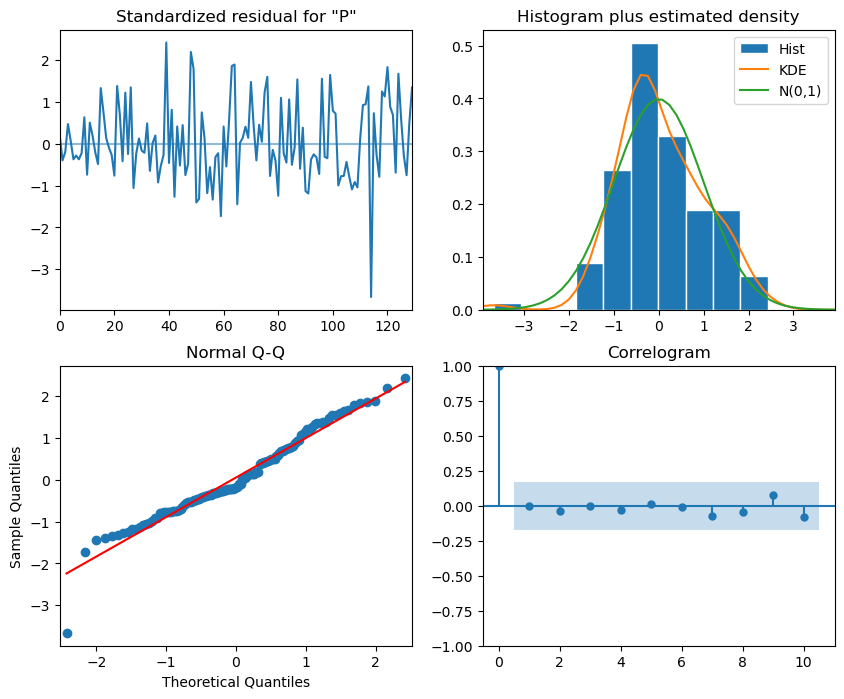

In [11]:
ARIMA_model = SARIMAX(train, order=(11, 2, 3), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

ARIMA_model_fit.plot_diagnostics(figsize=(10, 8));

In [13]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = ARIMA_model_fit.resid

ljungbox_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))
ljungbox_df

,lb_stat,lb_pvalue
1,6.440891,0.011152
2,6.551069,0.037797
3,6.818110,0.077927
4,7.623069,0.106403
5,8.261752,0.142388
6,8.562565,0.199714
7,9.407657,0.224697
8,9.640050,0.291204
9,9.648769,0.379660
10,11.411524,0.326368
